# EE P 596 - TinyML - Assignment 2

## Importing Libraries

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
import os
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
sns.set_theme()

from pylab import rcParams
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers,models
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
import c_writer
from os.path import join


seed = 47
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Reading Data

In [19]:
# Reading the data and adding column header (feature) names
data = pd.read_csv("Network_anomaly_data.txt",sep=",",names=["duration","protocoltype","service",
"flag","srcbytes","dstbytes","land", "wrongfragment","urgent","hot","numfailedlogins","loggedin", "numcompromised",
"rootshell","suattempted","numroot","numfilecreations", "numshells","numaccessfiles","numoutboundcmds","ishostlogin",
"isguestlogin","count","srvcount","serrorrate", "srvserrorrate","rerrorrate","srvrerrorrate","samesrvrate",
"diffsrvrate", "srvdiffhostrate","dsthostcount","dsthostsrvcount","dsthostsamesrvrate", "dsthostdiffsrvrate",
"dsthostsamesrcportrate","dsthostsrvdiffhostrate","dsthostserrorrate","dsthostsrvserrorrate","dsthostrerrorrate",
"dsthostsrvrerrorrate","attack", "lastflag"])

In [20]:
data # printing the dataframe

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


## Question 2: Data Preprocessing

##### (a) Drop the 'land', 'urgent', 'numfailedlogins', 'numoutboundcmds' columns from the dataframe "data".

In [21]:
cols_to_drop = ['land', 'urgent', 'numfailedlogins', 'numoutboundcmds']
data.drop(cols_to_drop, axis='columns', inplace=True)

In [22]:
print(f"All columns dropped: {not set(cols_to_drop).issubset(data.columns)}")

All columns dropped: True


##### (b) Change any label that is not named normal to attack in the {'attack'} column of the dataframe data.

In [23]:
data['attack'].value_counts()

attack
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

In [24]:
data.loc[data['attack'] != 'normal', 'attack'] = 'attack'

In [25]:
data['attack'].value_counts() #<--------- Print your modified dataframe "data"

attack
normal    67343
attack    58630
Name: count, dtype: int64

##### (c) Use LabelEncoder() function from the sklearn.preprocessing library to convert non-numerical attributes in the {'protocoltype', 'service', 'flag', 'attack'} columns of the dataframe data to numerical values.

In [26]:
le_protocoltype = LabelEncoder()
le_service = LabelEncoder()
le_flag = LabelEncoder()
le_attack = LabelEncoder()

data['protocoltype'] = le_protocoltype.fit_transform(data['protocoltype'])
data['service'] = le_service.fit_transform(data['service'])
data['flag'] = le_flag.fit_transform(data['flag'])
data['attack'] = le_attack.fit_transform(data['attack'])

In [27]:
pd.DataFrame(data) #<--------- Print your modified dataframe "data"

,duration,protocoltype,service,flag,srcbytes,dstbytes,wrongfragment,hot,loggedin,numcompromised,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,1,20,9,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1,20
1,0,2,44,9,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1,15
2,0,1,49,5,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0,19
3,0,1,24,9,232,8153,0,0,1,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1,21
4,0,1,24,9,199,420,0,0,1,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,1,49,5,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,0,20
125969,8,2,49,9,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,1,21
125970,0,1,54,9,2231,384,0,0,1,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,1,18
125971,0,1,30,5,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0,20


## Feature Scaling and Train/Test Split

In [28]:
# All the features apart from Attack are what we are going to use to predict the attack status of the data
# attack = 1 (normal/not an attack) and attack = 0 (attack)
X = data.drop(['attack'],axis=1).to_numpy()

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
X_normalized = scaler.fit_transform(X)

Y = data['attack'].to_numpy()
# Splitting X and y testing and training data
# we are taking 20% of the data for testing and 80% of the data for training
X_train, X_test, y_train, y_test = train_test_split(X_normalized, Y, test_size = 0.20)
# reshaping y test and train array
y_train = y_train.reshape(len(y_train),1)
y_test = y_test.reshape(len(y_test),1)

## Question 3: Dimensionality Reduction for Visualization

##### (a) Use TSNE from the sklearn.manifold library to visualize the data in the test set (X_test) in 2D. In your figure, use color "red" to mark {attack} data points and color "blue" to mark {normal} data points.

In [63]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=seed)
X_test_tsne = tsne.fit_transform(X_test)

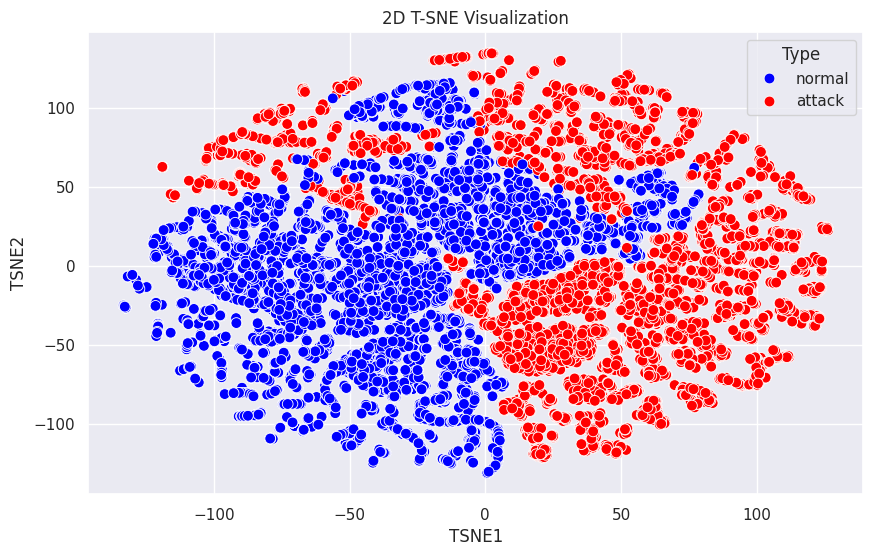

In [62]:
df_tsne = pd.DataFrame(X_test_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['label'] = le_attack.inverse_transform(y_test)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='label', data=df_tsne, palette={'attack': 'red', 'normal': 'blue'}, s=60)
plt.title('2D T-SNE Visualization')
plt.legend(title='Type', loc='best')
plt.show()

##### (b) Use PCA from the sklearn.decomposition library to visualize the data in the test set (X_test) in 2D. In your figure, use color "red" to mark {attack} data points and color "blue" to mark {normal} data points.

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=seed)
X_test_pca = pca.fit_transform(X_test)

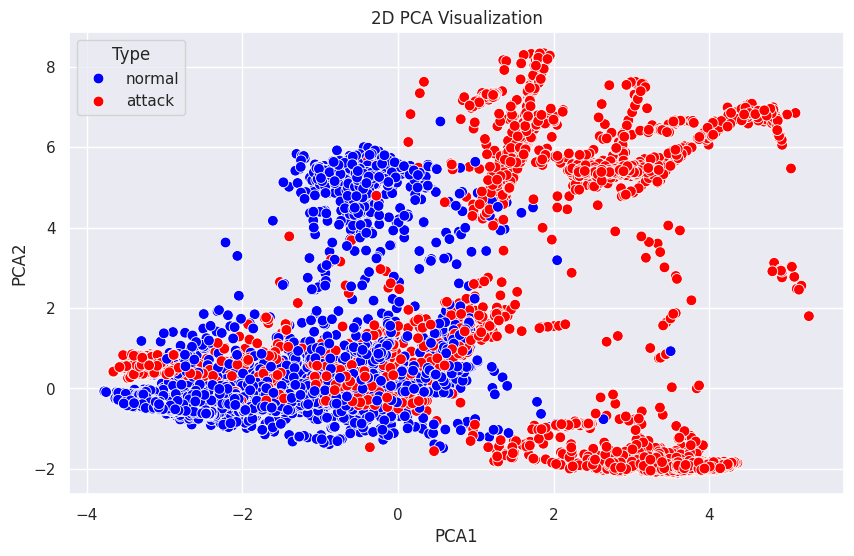

In [32]:
df_pca = pd.DataFrame(X_test_pca, columns=['PCA1', 'PCA2'])
df_pca['label'] = le_attack.inverse_transform(y_test)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=df_pca, palette={'attack': 'red', 'normal': 'blue'}, s=60)
plt.title('2D PCA Visualization')
plt.legend(title='Type', loc='best')
plt.show()

##### (c) Use KernelPCA from the sklearn.decomposition library to visualize the data in the test set (X_test) in 2D. Use radial basis function (rbf) as the kernel. In your figure, use color "red" to mark {attack} data points and color "blue" to mark {normal} data points.

In [33]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=2, kernel='rbf', random_state=seed)
X_test_kpca = kpca.fit_transform(X_test)

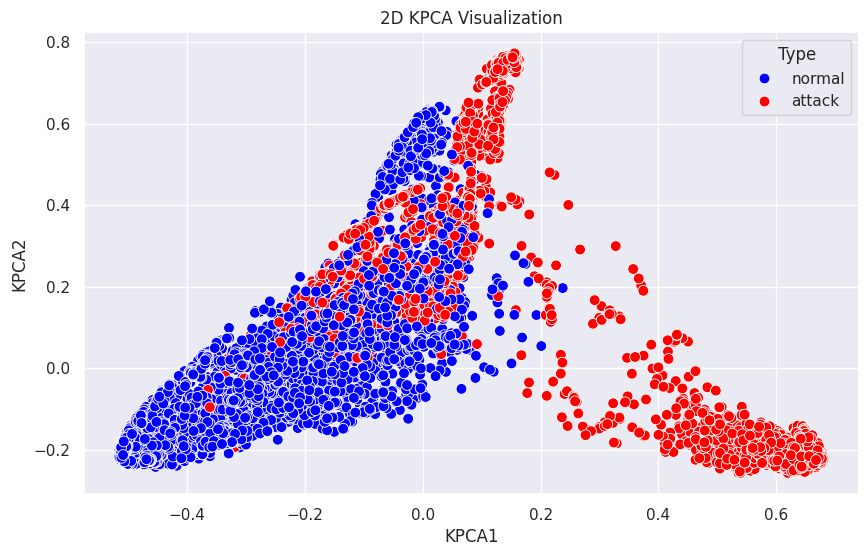

In [34]:
df_kpca = pd.DataFrame(X_test_kpca, columns=['KPCA1', 'KPCA2'])
df_kpca['label'] = le_attack.inverse_transform(y_test)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='KPCA1', y='KPCA2', hue='label', data=df_kpca, palette={'attack': 'red', 'normal': 'blue'}, s=60)
plt.title('2D KPCA Visualization')
plt.legend(title='Type', loc='best')
plt.show()

## Question 4: Implementing a DNN on the dataset

##### (a) Implement a deep neural network (DNN) on the Network Anomaly Dataset. Ensure to include two neurons and softmax activation in the output layer of your DNN.

In [35]:
base_model = Sequential([
    Input(shape=(X_train.shape[1])),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(2, activation='softmax')
])

##### (b) Compile and train your DNN model on the training set (X_train). Denote the trained model as base_model.

In [36]:
base_model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics = ["accuracy"]
)

base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                624       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
Total params: 778 (3.04 KB)
Trainable params: 778 (3.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
history = base_model.fit(X_train, y_train, epochs=10, batch_size=512, shuffle=False)

Epoch 1/10
197/197 [==============================] - 2s 3ms/step - loss: 0.2271 - accuracy: 0.9148
Epoch 2/10
197/197 [==============================] - 1s 5ms/step - loss: 0.0403 - accuracy: 0.9895
Epoch 3/10
197/197 [==============================] - 1s 5ms/step - loss: 0.0276 - accuracy: 0.9926
Epoch 4/10
197/197 [==============================] - 1s 5ms/step - loss: 0.0222 - accuracy: 0.9936
Epoch 5/10
197/197 [==============================] - 1s 4ms/step - loss: 0.0188 - accuracy: 0.9942
Epoch 6/10
197/197 [==============================] - 1s 5ms/step - loss: 0.0164 - accuracy: 0.9945
Epoch 7/10
197/197 [==============================] - 1s 3ms/step - loss: 0.0146 - accuracy: 0.9951
Epoch 8/10
197/197 [==============================] - 1s 3ms/step - loss: 0.0134 - accuracy: 0.9954
Epoch 9/10
197/197 [==============================] - 1s 3ms/step - loss: 0.0124 - accuracy: 0.9957
Epoch 10/10
197/197 [==============================] - 1s 3ms/step - loss: 0.0116 - accuracy: 0.9958

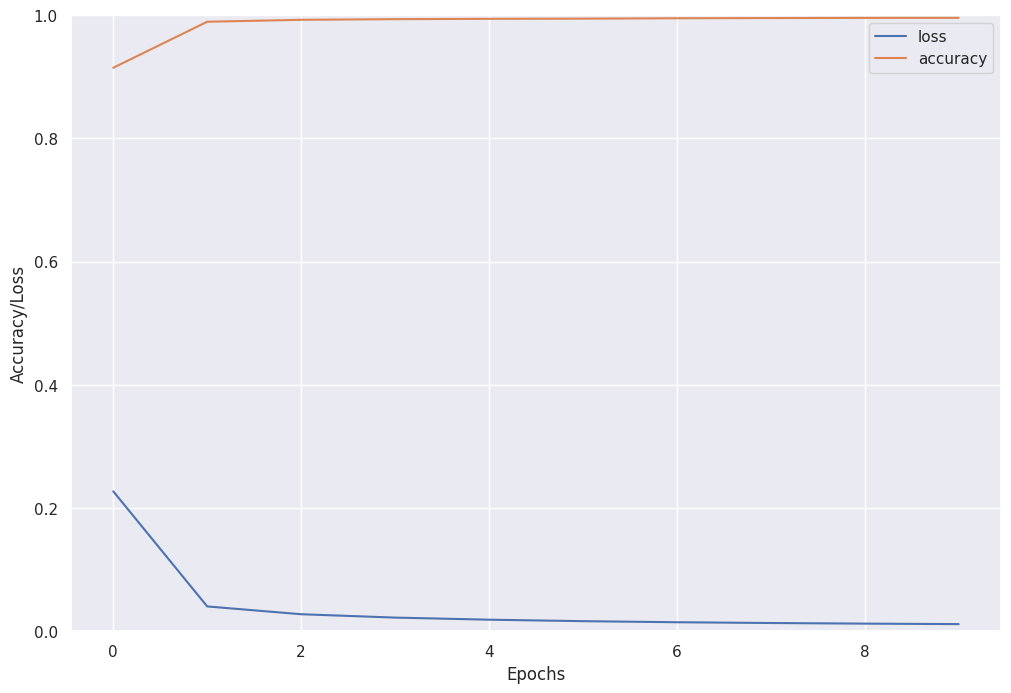

In [38]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.show()

##### (c) Evaluate the base_model on the test set (X_test) using classification_report and confusion_matrix from the sklearn.metrics library. Report these numbers in your .pdf writeup file using screenshots.

In [39]:
_, baseline_model_accuracy = base_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {baseline_model_accuracy*100:.2f}%")

Test Accuracy: 99.58%


In [40]:
predictions = np.argmax(base_model.predict(X_test, verbose=0), axis=1)

In [41]:
class_report = classification_report(y_test, predictions)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     11771
           1       1.00      0.99      1.00     13424

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



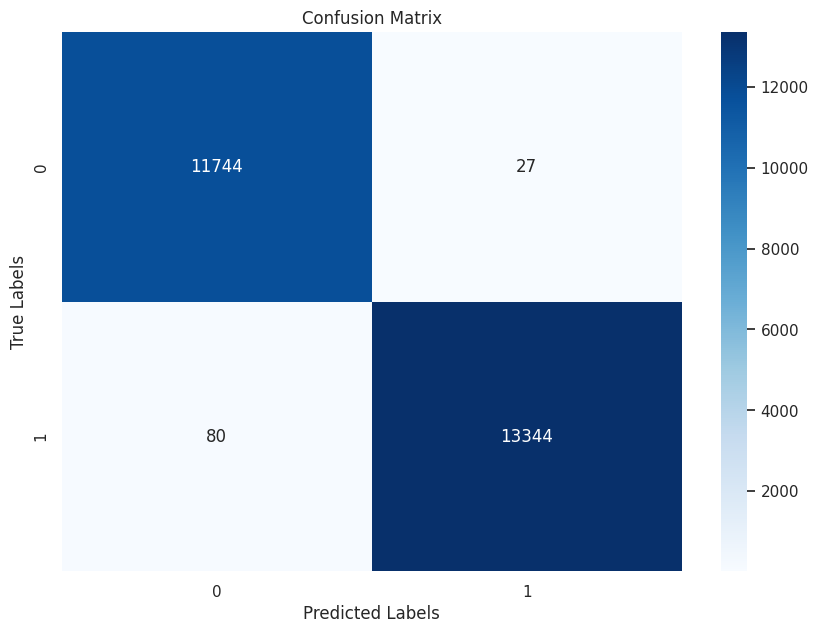

In [42]:
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 7))  # Set the figure size for better readability
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [43]:
# Save the original Keras model to HDF5 file
base_model.save('original_model.h5')

## Question 5: Implementing Quantized Model

##### (a) Implement Dynamic Range Quantization on the base_model. Designate the resulting quantized ML model as tflite_quant_model.

In [44]:
# Load the trained model
base_model = tf.keras.models.load_model('original_model.h5')

drq_converter = tf.lite.TFLiteConverter.from_keras_model(base_model)
drq_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = drq_converter.convert()

In [45]:
import os
import tempfile


# Save the quantized model
_, tflite_quant_file = tempfile.mkstemp('.tflite')
with open(tflite_quant_file, 'wb') as f:
    f.write(tflite_quant_model)

# Get the file sizes
original_model_size = os.path.getsize('original_model.h5')
quantized_model_size = os.path.getsize(tflite_quant_file)

# Print the model sizes
print(f"Original model size: {original_model_size / 1024:.2f} KB")
print(f"Quantized model size: {quantized_model_size / 1024:.2f} KB")

Original model size: 38.59 KB
Quantized model size: 5.08 KB


##### (b) Evaluate the tflite_quant_model on the test set (X_test) using classification_report and confusion_matrix from the sklearn.metrics library. Report these numbers in your .pdf writeup file using screenshots.

In [46]:
drq_interpreter = tf.lite.Interpreter(tflite_quant_file)
drq_interpreter.allocate_tensors()

In [47]:
def evaluate(interpreter, features, labels):
    prediction= []
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    input_format = interpreter.get_input_details()[0]['dtype']

    for i, f in enumerate(features):
        f = np.expand_dims(f, axis=0).astype(input_format)

        interpreter.set_tensor(input_index, f)

        # Run inference.
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        predicted_label = np.argmax(output()[0])
        prediction.append(predicted_label)

    return prediction

In [48]:
tflite_predictions = evaluate(drq_interpreter, X_test, y_test)

In [49]:
tflite_class_report = classification_report(y_test, tflite_predictions)
print("TFLite Classification Report:")
print(tflite_class_report)

TFLite Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     11771
           1       1.00      0.99      1.00     13424

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



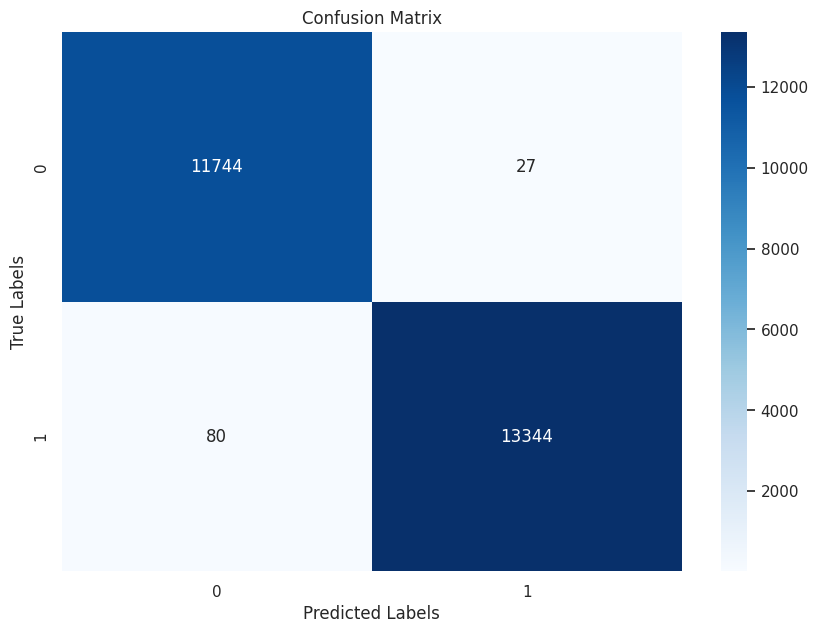

In [50]:
tflite_conf_matrix = confusion_matrix(y_test, tflite_predictions)

plt.figure(figsize=(10, 7))  # Set the figure size for better readability
sns.heatmap(tflite_conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Converting tflite_model to C and create the header file

In [51]:
# c_writer is a py file in the same folder and has been imported at the beginning of the notebook
# Reference : https://github.com/ShawnHymel/tinyml-example-anomaly-detection/blob/master/utils/c_writer.py
# We use #04x to pad the output to 2 digits with a 0x prefix
hex_array = [format(val, '#04x') for val in tflite_quant_model]
# Calling function to convert an array into a C string (requires Numpy)
# create_array(np_array, var_type, var_name, line_limit=80, indent=4)
c_model = c_writer.create_array(np.array(hex_array), 'unsigned char', "network_model")
# Calling Function to create a header file with given C code as a string
header_str = c_writer.create_header(c_model, "network_model")

In [52]:
#Writing to the header file
with open('network_model.h', 'w') as file:
    file.write(header_str)

## Generating Samples for Inference on Arduino

In [55]:
# Converting a sample piece of the X test and y test data to C (for the purpose of ino code (arduino) to load and test
# the sample and compare

Xtest = X_test[5:15,:]
print(c_writer.create_array(Xtest,"float","X_test"))

const unsigned int X_test_dim1 = 10;
const unsigned int X_test_dim2 = 38;

const float X_test[10][38] = {
    -0.11024922321249885, -0.12470615670462065, -0.44208308523109213, 
    0.7511112872365361, -0.007728682023723982, -0.00482787665965922, 
    -0.08948642202040107, -0.09507567152556495, 1.2356940323701657, 
    -0.011663642603760032, -0.036651869142258646, -0.024436507262009306, 
    -0.01238515036740332, -0.02618002418454278, -0.018609896340735923, 
    -0.04122119759327531, -0.0028174939213690777, -0.0975309439715147, 
    -0.5685844472139162, 0.09998012801771435, -0.6372092679572258, 
    -0.6319290328885425, -0.37436223991967527, -0.37443160310530493, 
    0.7712831058493207, -0.349683030873482, 0.04879489561066655, 
    0.7343425609306344, 1.2587542737799418, 1.0664013456654926, 
    -0.43907816809041417, -0.4801968475158174, -0.28910340026287856, 
    -0.6395319051152512, -0.6248707997445304, -0.38763462350750655, 
    -0.3763870260680415, 0.6528228780141483, -0.1102492232

In [56]:
ytest=y_test[5:15]
print(c_writer.create_array(ytest,"uint8_t","y_test"))

const unsigned int y_test_dim1 = 10;
const unsigned int y_test_dim2 = 1;

const uint8_t y_test[10][1] = {
    1, 0, 1, 1, 1, 1, 0, 0, 0, 0
};

